In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Dict, List

import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import ufl

from dolfin import inner, grad, div

from pantarei import forms, solvers, mms, boundary, elements
from pantarei.boundary import *
from pantarei.domain import Domain
from pantarei.mms import MMSDomain

from collections import defaultdict

In [3]:
from multirat.parameters import multicompartment_parameters

## Pressure Equations 

In [4]:
def compartment_pressure_form(idx_j, p, q, K, gamma, compartments):
    j = compartments[idx_j]
    sj = sum([
        gamma[(i, j)] * (p[idx_i] - p[idx_j]) * q[idx_j]
        for idx_i, i in enumerate(compartments)
        if idx_i != idx_j
    ])
    return (K[j] * inner(grad(p[idx_j]), grad(q[idx_j])) - sj)


def multicompartment_pressure_form(compartments):
    class MulticompartmentPressure:
        @staticmethod
        def create_fem_form(
                    V: df.FunctionSpace,
                    coefficients: Dict[str, ufl.Coefficient],
                    boundaries: Dict[int, List[BoundaryData]]
                ) -> df.Form:
            dx = Measure("dx", domain=V.mesh())
            p = df.TrialFunction(V)
            q = df.TestFunction(V)
            K = coefficients["hydraulic_conductivity"]
            gamma = coefficients["convective_fluid_transfer"]
            return (
                sum([compartment_pressure_form(idx_j, p, q, K, gamma, compartments)
                        for idx_j, j in enumerate(compartments)]) * dx
                 + process_boundary_forms(p, q, V.mesh(), boundaries))
                
    return MulticompartmentPressure

Object cannot be plotted directly, projecting to piecewise linears.


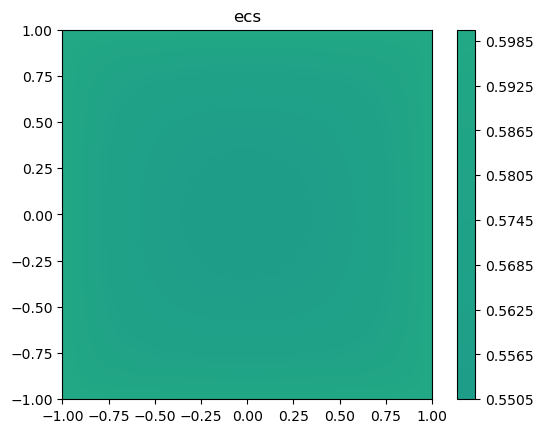

Object cannot be plotted directly, projecting to piecewise linears.


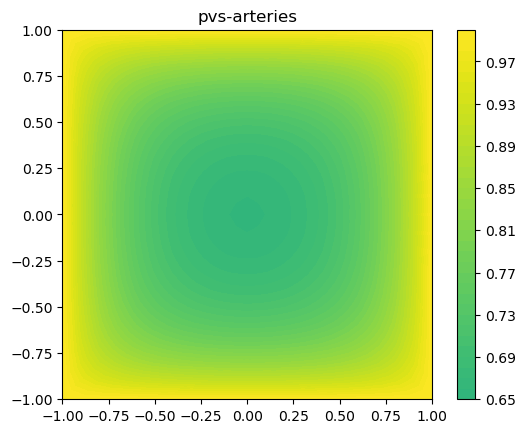

Object cannot be plotted directly, projecting to piecewise linears.


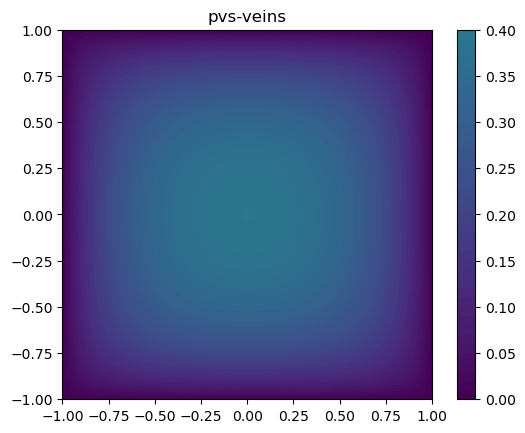

In [5]:
coefficients = defaultdict(lambda: defaultdict(lambda: 1.0))
coefficients["hydraulic_conductivity"] = defaultdict(lambda: 0.5)
p_bdry = {"ecs": 0.6, "pvs-arteries": 1.0, "pvs-veins": 0.0}

n = 20
domain = MMSDomain(n)
compartments = ["ecs", "pvs-arteries", "pvs-veins"]
element = df.MixedElement(
    [df.FiniteElement("CG", ufl.Cell('triangle'), degree=1)] * len(compartments)
)

pressure_form = multicompartment_pressure_form(compartments)

boundaries = {
    idx_j: [DirichletBoundary(df.Constant(p_bdry[j]), "everywhere")]
    for idx_j, j in enumerate(compartments)
}
boundaries = indexed_boundary_conditions(boundaries)

problem = solvers.StationaryProblem(
    domain,
    element,
    coefficients=coefficients,
    form=pressure_form,
    boundaries=boundaries,
    solver=solvers.StationaryProblemSolver("lu", "none"),
    name="pressure"
)
P = problem.solve()

for idx_j, j in enumerate(compartments):
    plt.title(j)
    c = df.plot(P[idx_j], vmin=0.0, vmax=1.0)
    plt.colorbar(c)
    plt.show()

## Solute Transport

In [6]:
def multicompartment_solute_form(compartments):
    class MulticompartmentConcentration:
        @staticmethod
        def create_fem_form(
            V: FunctionSpace,
            coefficients: Dict[str, Coefficient],
            boundaries: List[BoundaryData]
        ) -> df.Form:
            dx = Measure("dx", domain=V.mesh())
            u = df.TrialFunction(V)
            v = df.TestFunction(V)
            L = coefficients["diffusive_solute_transfer"]
            G = coefficients["convective_solute_transfer"]
            p = coefficients["pressure"]
            phi = coefficients["porosity"]
            dt = coefficients["dt"]
            u0 = coefficients["u0"]
            D = coefficients["effective_diffusion"]
            K = coefficients["hydraulic_conductivity"]
            return (
                sum([compartment_concentration_form(idx_j, u, v, u0, L, G, p, phi, dt, D, K, compartments)
                     for idx_j, j in enumerate(compartments)]) * dx
                + dt * process_boundary_forms(u, v, V.mesh(), boundaries)
            )
        
    return MulticompartmentConcentration

def compartment_concentration_form(idx_j, u, v, u0, L, G, p, phi, dt, D, K, compartments):
    j = compartments[idx_j]
    diffusive_transfer = sum([
        L[(i, j)] * (u[idx_i] - u[idx_j]) 
        for idx_i, i in enumerate(compartments)
        if idx_i != idx_j
    ])
    convective_transfer = 0.5 * sum([
        0.5 * G[(i, j)] * (p[idx_i] - p[idx_j]) * (u[idx_i] + u[idx_j])
        for idx_i, i in enumerate(compartments)
        if idx_i != idx_j
    ])
    rj = (convective_transfer + diffusive_transfer) / phi[j]
    return (
        (u[idx_j] - u0[idx_j] - dt * rj) * v[idx_j]
        + dt * inner(D[j] * grad(u[idx_j]) + K[j] / phi[j] * u[idx_j] * grad(p[idx_j]), grad(v[idx_j]))
    )

In [7]:
from multirat.initial_conditions import gaussian_expression

In [8]:
coefficients = defaultdict(lambda: defaultdict(lambda: 1.0))
coefficients["hydraulic_conductivity"] = defaultdict(lambda: 0.5)
coefficients["effective_diffusion"] = defaultdict(lambda: 0.05)
p_bdry = {"ecs": 0.6, "pvs-arteries": 1.0, "pvs-veins": 0.0}

In [9]:
from multirat.utils import assign_mixed_function
def create_multicompartment_projector(compartments, projector):
    def project(u0, V, bcs):
        U = assign_mixed_function(u0, V, compartments)
        return projector(U, V, bcs)
    return project

In [16]:
from multirat.boundary_conditions import TracerODEBoundary

In [78]:
def compartment_flux_density(Dj, cj, Kj, phi_j, pj):
    return Dj * grad(cj) + (Kj / phi_j) * cj * grad(pj)


def total_flux_density(C, P, coefficients, compartments):
    D, K, phi = (
        coefficients[param] for param in [
            "effective_diffusion",
            "hydraulic_conductivity",
            "porosity"
        ])
    return sum(
        [compartment_flux_density(D[j], C[idx_j], K[j], phi[j], P[idx_j])
            for idx_j, j in enumerate(compartments)]
    )


class TracerODEBoundary(DirichletBoundary):
    pass


class TracerConservationBoundary(TracerODEBoundary):
    def __init__(self, domain, coefficients, compartments, time):
        super().__init__(df.Constant(0.0), "everywhere")
        self.coefficients = coefficients
        self.time = time
        self.ds = Measure("ds", domain=domain)
        self.n = FacetNormal(domain)
        
    def update(self, u0):
        q = total_flux_density(u0, self.coefficients["pressure"], coefficients, compartments)
        self.uD.assign(self.uD - self.time.dt * df.assemble(inner(q, self.n) * self.ds))


class TracerDecayBoundary(TracerODEBoundary):
    def __init__(self, domain, coefficients, compartments, time):
        super().__init__(df.Constant(0.0), "everywhere")
        self.coefficients = coefficients
        self.time = time
        self.ds = Measure("ds", domain=domain)
        self.n = FacetNormal(domain)
        self.decay = coefficients["csf_renewal_rate"]

    def update(self, u0):
        q = total_flux_density(u0, self.coefficients["pressure"], coefficients, compartments)
        self.uD.assign(
            df.exp(-self.decay * self.time.dt)
            * (self.uD - self.time.dt * df.assemble(inner(q, self.n) * self.ds))
        )


class TracerODEProblemSolver:
    def __init__(self, stationarysolver, bdries: DirichletBoundary):
        self.solver = stationarysolver
        self.bdries = bdries
        
    def solve(self, u, A, b, dirichlet_bcs):
        for bdry in self.bdries:
            if hasattr(bdry, "bc") and isinstance(bdry.bc, TracerODEBoundary):
                    bdry.bc.update(u)
        return self.solver.solve(u, A, b, dirichlet_bcs)

In [92]:
from pantarei.solvers import solve_time_dependent
from pantarei.io import TimeSeriesStorage
from pantarei.io.fenicsstorage import FenicsStorage
from pantarei.timekeeper import TimeKeeper
from pantarei.projectors import create_smoothing_projection

dt = 0.1
T  = 20.0
time = TimeKeeper(dt, T)
coefficients["csf_renewal_rate"] = 1.0

boundaries = {
    idx_j: [TracerConservationBoundary(domain, coefficients, compartments, time)]
    for idx_j, j in enumerate(compartments)
}
boundaries = {
    idx_j: [TracerDecayBoundary(domain, coefficients, compartments, time)]
    for idx_j, j in enumerate(compartments)
}
boundaries = indexed_boundary_conditions(boundaries)
solute_form = multicompartment_solute_form(compartments)

U0 = {
    "ecs": gaussian_expression([0, 0], 1.0, degree=1),
    "pvs-arteries": df.Constant(0.0),
    "pvs-veins": df.Constant(0.0)
}
coefficients["dt"] = dt
coefficients["pressure"] = P

stationary_solver = solvers.StationaryProblemSolver("lu", "none")

time.reset()
computer = solve_time_dependent(
    domain=domain,
    element=element,
    coefficients=coefficients,
    form=solute_form,
    boundaries=boundaries,
    initial_condition=U0,
    time=time,
    solver=TracerODEProblemSolver(stationary_solver, boundaries),
    storage_path="mc-concentration/mc-concentration.h5",
    name="concentrations",
    computer=None,
    projector=create_multicompartment_projector(compartments, create_smoothing_projection(0.1))
    #projector=create_multicompartment_projector(compartments, df.project)
)
storage = FenicsStorage("mc-concentration/mc-concentration.h5", "r")
storage.to_xdmf("concentrations", compartments)
storage.close()

f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711
f_89712
f_89710
f_89711


In [43]:
def multicompartment_model():
    domain = load_mesh()
    P = solve_pressaure()
    C0 = project_initial_condition()
    C = solve_concentration()